# COGS 118A - Group 010 - Final Project

# Song Genre Classification

## Group members

- David Soberanis
- Ernest Lin
- Felipe Lorenzi
- Shushruth Kallutla
- John (Morgan) Harrison

---

# Abstract 

This program intends to use songs' audio features to classify them into their correct genre. Our features, provided by the Spotify API, include both low-level features, such as loudness, which are measured through signal processing methods on the audio tracks, and high-level features such as danceability, Instrumentalness, and liveliness, which are derived by Spotify from the low-level features using undisclosed methods. Some of these are utilized, and some are dropped based on our exploratory data analysis, and we determined the most useful features to include in order to not overfit our model. The genres of the songs are not provided by the Spotify API; rather, we will be using a dataset from Kaggle which contains the genres of many songs. We then took this data and compared it across multiple different models to determine the best model for fitting these features, by comparing F-scores between our train and test data. We found that our most successful model of determining genre was K-nearest neighbors, using PCA, and a k of 10. 

# Background

Musical genres are often umbrella terms which group songs with very distinct styles. However, some features, such as the rhythm, construction of the drum beat, instrumentation, presence of vocals, and others, can be useful for correctly classifying the genre of a song <a name="biss"></a>[<sup>[1]</sup>](#bissnote). According to some, the classification of genres is often socially-driven, rather than based on the features of the songs themselves, placing songs into genres with the intention of targeting specific groups of listeners and making profit <a name="tagg"></a>[<sup>[2]</sup>](#taggnote) <a name="greenberg"></a>[<sup>[3]</sup>](#greenbergnote).

However, relatively recent research uncovered that songs often cluster into three distinct categories: "“Arousal” (the energy level of the music); “Valence” (the spectrum from sad to happy emotions in the music); and “Depth” (the amount of sophistication and emotional depth in the music)" <a name="greenberg"></a>[<sup>[3]</sup>](#greenbergnote).

It would be interesting to understand if other musical features could be useful for classifying songs into genres. This could uncover new rule-sets for music genre recognition by analyzing which features are most associated with which genres. The features present in the Spotify API appear to be promising for this task as they include the features aforementioned of valence, arousal and depth and more. In addition, the Spotify API provides more low-level musical features which can be extracted from the audio signal of a song, and many examples can be found online of people classifying songs into genres based only on these low-level features, with some success <a name="venturott"></a>[<sup>[4]</sup>](#venturottnote) <a name="elbir"></a>[<sup>[5]</sup>](#elbirnote).

Models for genre recognition could be useful for providing features to music recommendation systems, such as Spotify's itself. Furthermore, it is no news that knowing the genre of a song is useful for listeners to find songs they like, however having an automatic approach which only takes into account the actual musical features of a song could make the process faster and more fruitful to users.

# Problem Statement

Our project aims to use supervised machine learning techniques to classify songs on Spotify into distinct Generes. By doing so, we hope to explore the underlying features that characterize each genere and the criterias that differentiate various generes.

# Data

We downloaded our dataset from the following source: https://www.kaggle.com/datasets/grasslover/spotify-music-genre-list?resource=download&select=songDb.tsv

This is a Spotify music genre list with 131,580 rows and 20 columns. Each row contains a song, while the columns contain song features from Spotify's API. These features include: Danceability, Energy, Key, Loudness, Mode, Speedchness, Acousticness, Instrumentalness, Liveness, Valence, Tempo, Time Signature, and Duration. The rest of the columns contain information regarding the location of the song in Spotify.

Our initial dataset contained 2800 unique genres to start. This is an issue, as many of these genres were too specific. For example: 'Minecraft music'. We considered grouping these genres into more general categories, but this led to malgrouped data and mediocre results. We believe this is due to the subjective nature of music genres.
  
We kept only the songs belonging to the top 5 genres (by number of songs).

After this, our working dataset is composed of:
- 5,750 songs
- 13 features: Danceability, Energy, Key, Loudness, Mode, Speechness, Acousticness, Instrumentalness, Liveness, Valence, Tempo, Duration_ms, time_signature
- 5 target groups: alternativeamericana, electrolatino, doo-wop, reading, and nuelectro

In [1]:
# import pandas & numpy library
import pandas as pd
import numpy as np

# imoprt seaborn & matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# import KNN from sklearn
from sklearn.neighbors import KDTree

# shows a bigger plot size for readability 
plt.rcParams['figure.figsize'] = (12, 5)
#improve resolution
%config InlineBackend.figure_format ='retina'


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score, confusion_matrix

# read 'songDb.tsv' into dataframe with correct encoding  
music = pd.read_csv('songDb.tsv', sep='\t', encoding='ISO-8859-1')

/tmp/ipykernel_115/3134232340.py:26: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  music = pd.read_csv('songDb.tsv', sep='\t', encoding='ISO-8859-1')


### Cleaning and Filtering rows
- gets rid of NaN values
- removes all songs that are not in the top 5 genres
- fixes indexing 
- fixes dtypes

In [2]:
df = music # for testing

df = df.rename({'Genre':'genres'}, axis='columns') # rename to match 
df = df.dropna()

# combines subgenres into more general Genres. This function removes all genres outside of the top 5.
# You can alter this to include more than the top 5 genres
def CombineGenre(str_in):

    try:
        str_in = str_in.lower()
        str_in = str_in.strip()
        
        if 'alternativeamericana' in str_in:
            output = 'Alternative'
        elif 'electrolatino' in str_in:
            output = 'Electrolatino'
        elif 'doo-wop' in str_in:
            output = 'Doo-wop'
        elif 'reading' in str_in:
            output = 'Reading'
        elif 'nuelectro' in str_in:
            output = 'Nuelectro'
        else:
            output  = np.nan
    except:
        output = np.nan
        
    return output

# applys above function to combine genres
df['genres'] = df['genres'].apply(CombineGenre)
df = df.dropna() # removes all genres that were not combined before 
df = df.reset_index() # resets the index since we removed many rows
# df # shows now filtered df of music
# df['genres'].value_counts() # shows number of songs in each top 5 genres

feature_cols = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode',
                'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence',
                'Tempo', 'Duration_ms', 'time_signature']

df[feature_cols] = df[feature_cols].astype(np.float64)



### Create Design Matrix and Target vectors from the now filtered Df 

In [3]:
# Start by removing all columns that are not features 

feature_cols = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode',
                'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence',
                'Tempo', 'Duration_ms', 'time_signature']
target_col = 'genres'

X = df[feature_cols]
y = df[target_col]

print(f'Feature cols: {feature_cols}')
print(f'Target: {target_col}')

Feature cols: ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'time_signature']
Target: genres


### Reduce features from 13 to 6 and do train test split

In [4]:
# take a subset of the data 10% OR any other subset

full_data = df[feature_cols + [target_col]]
df_small = full_data.groupby('genres').apply(lambda x: x.sample(frac = 0.99, random_state = 0)).reset_index(
    drop = True)


# This is a small set for testing 
X_small = df_small[feature_cols]
y_small = df_small[target_col]

# Create train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, stratify=y_small, test_size=0.2, random_state=42)

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (4553, 13)
Testing shape: (1139, 13)


# Proposed Solution

We will investigate different models for classifying the songs into the appropriate genre based on its features. 

Since we assume that song features of a genre are similar, we determined that using k-nearest neighbors could be a suitable solution to this problem. The features of a song (valence, danceability, etc) will be used to calculate the distance of a song to other labeled songs within a specific proximity to determine what genre a song most resembles out of all the labeled data that were given. 

We also intend to try logistic regression, support vector machines and neural networks and evaluate which scores highest given our metrics.

We will use linear regression as a benchmark model to compare to our solution.

# Evaluation Metrics

- We will use cross validation for selecting the most appropriate kind of model, as well as for hyperparameter tuning within different model kinds. For comparing models and hyperparameters, we intend to use the F-1 score. This test combines the precision and recall of a classifier into a single metric by using their harmonic mean. This will allow us to compare if classifier A has better recall or precision when compared to B then we can further test to see if precision is more important than recall or vice versa. 

- F1 score formula

\begin{align}
        F1 = \frac{2 \ }{ \frac{1}{Recall} + \frac{1}{Precision}}
    \end{align}

- Precision: Number of correct positives divided by the number of total positive results predicted by the classifier

\begin{align}
        Precision = \frac{TruePositive \ }{True Positive + False Positive }
    \end{align}
    
- Recall: Number of correct positives divided by the number of all samples that should have been identified as positive 

\begin{align}
        Recall = \frac{TruePositive \ }{True Positive + False Negative }
    \end{align}

- For classification accuracy, we will use a confusion matrix. A confusion matrix is used to evaluate the accuracy of a multiclass classifier model<a name="confusion matrix"></a>[<sup>[10]</sup>](#confusionmatrix). Since we will be classifying songs by genres a confusion matrix will help us benchmark our classifier model. The way the confusion matrix works is one has predicted classes on the columns and actual classes on the rows. These predicted and actual classes are matched up for comparison. For example cell (1x1) could represent a true positive for the genre 'Rock' if the first row is an actual classification for 'Rock' and the first row is the predicted classification for 'Rock.' There are True Positives, True Negatives, False Positives, and False Negatives. Our data will include the genre of the songs which we will use for our (actual) classification in the matrix. After the confusion matrix is created we will calculate the accuracy of our model with the following:

\begin{align}
        Accuracy = \frac{TruePositive + TrueNegative \ }{TotalSample}
    \end{align}
- We can also test the sensitivity of our model with the following:

\begin{align}
        Sensitivity = \frac{TruePositive \ }{False Negative + True Positive}
    \end{align}

# Results

### EDA

We found that the features 'Danceability', 'Loudness', and 'Acousticness' showed the greatest variance across genres. Furthermore, it is clear that the genre 'Reading' is the most distinct genre in terms of its representation in the feature-space.

We also found two feature interactions that looked promising for separating the 'Reading' genre from the others. These were interactions between 'Acousticness' and 'Instrumentalness', and between 'Danceability' and 'Loudness'.

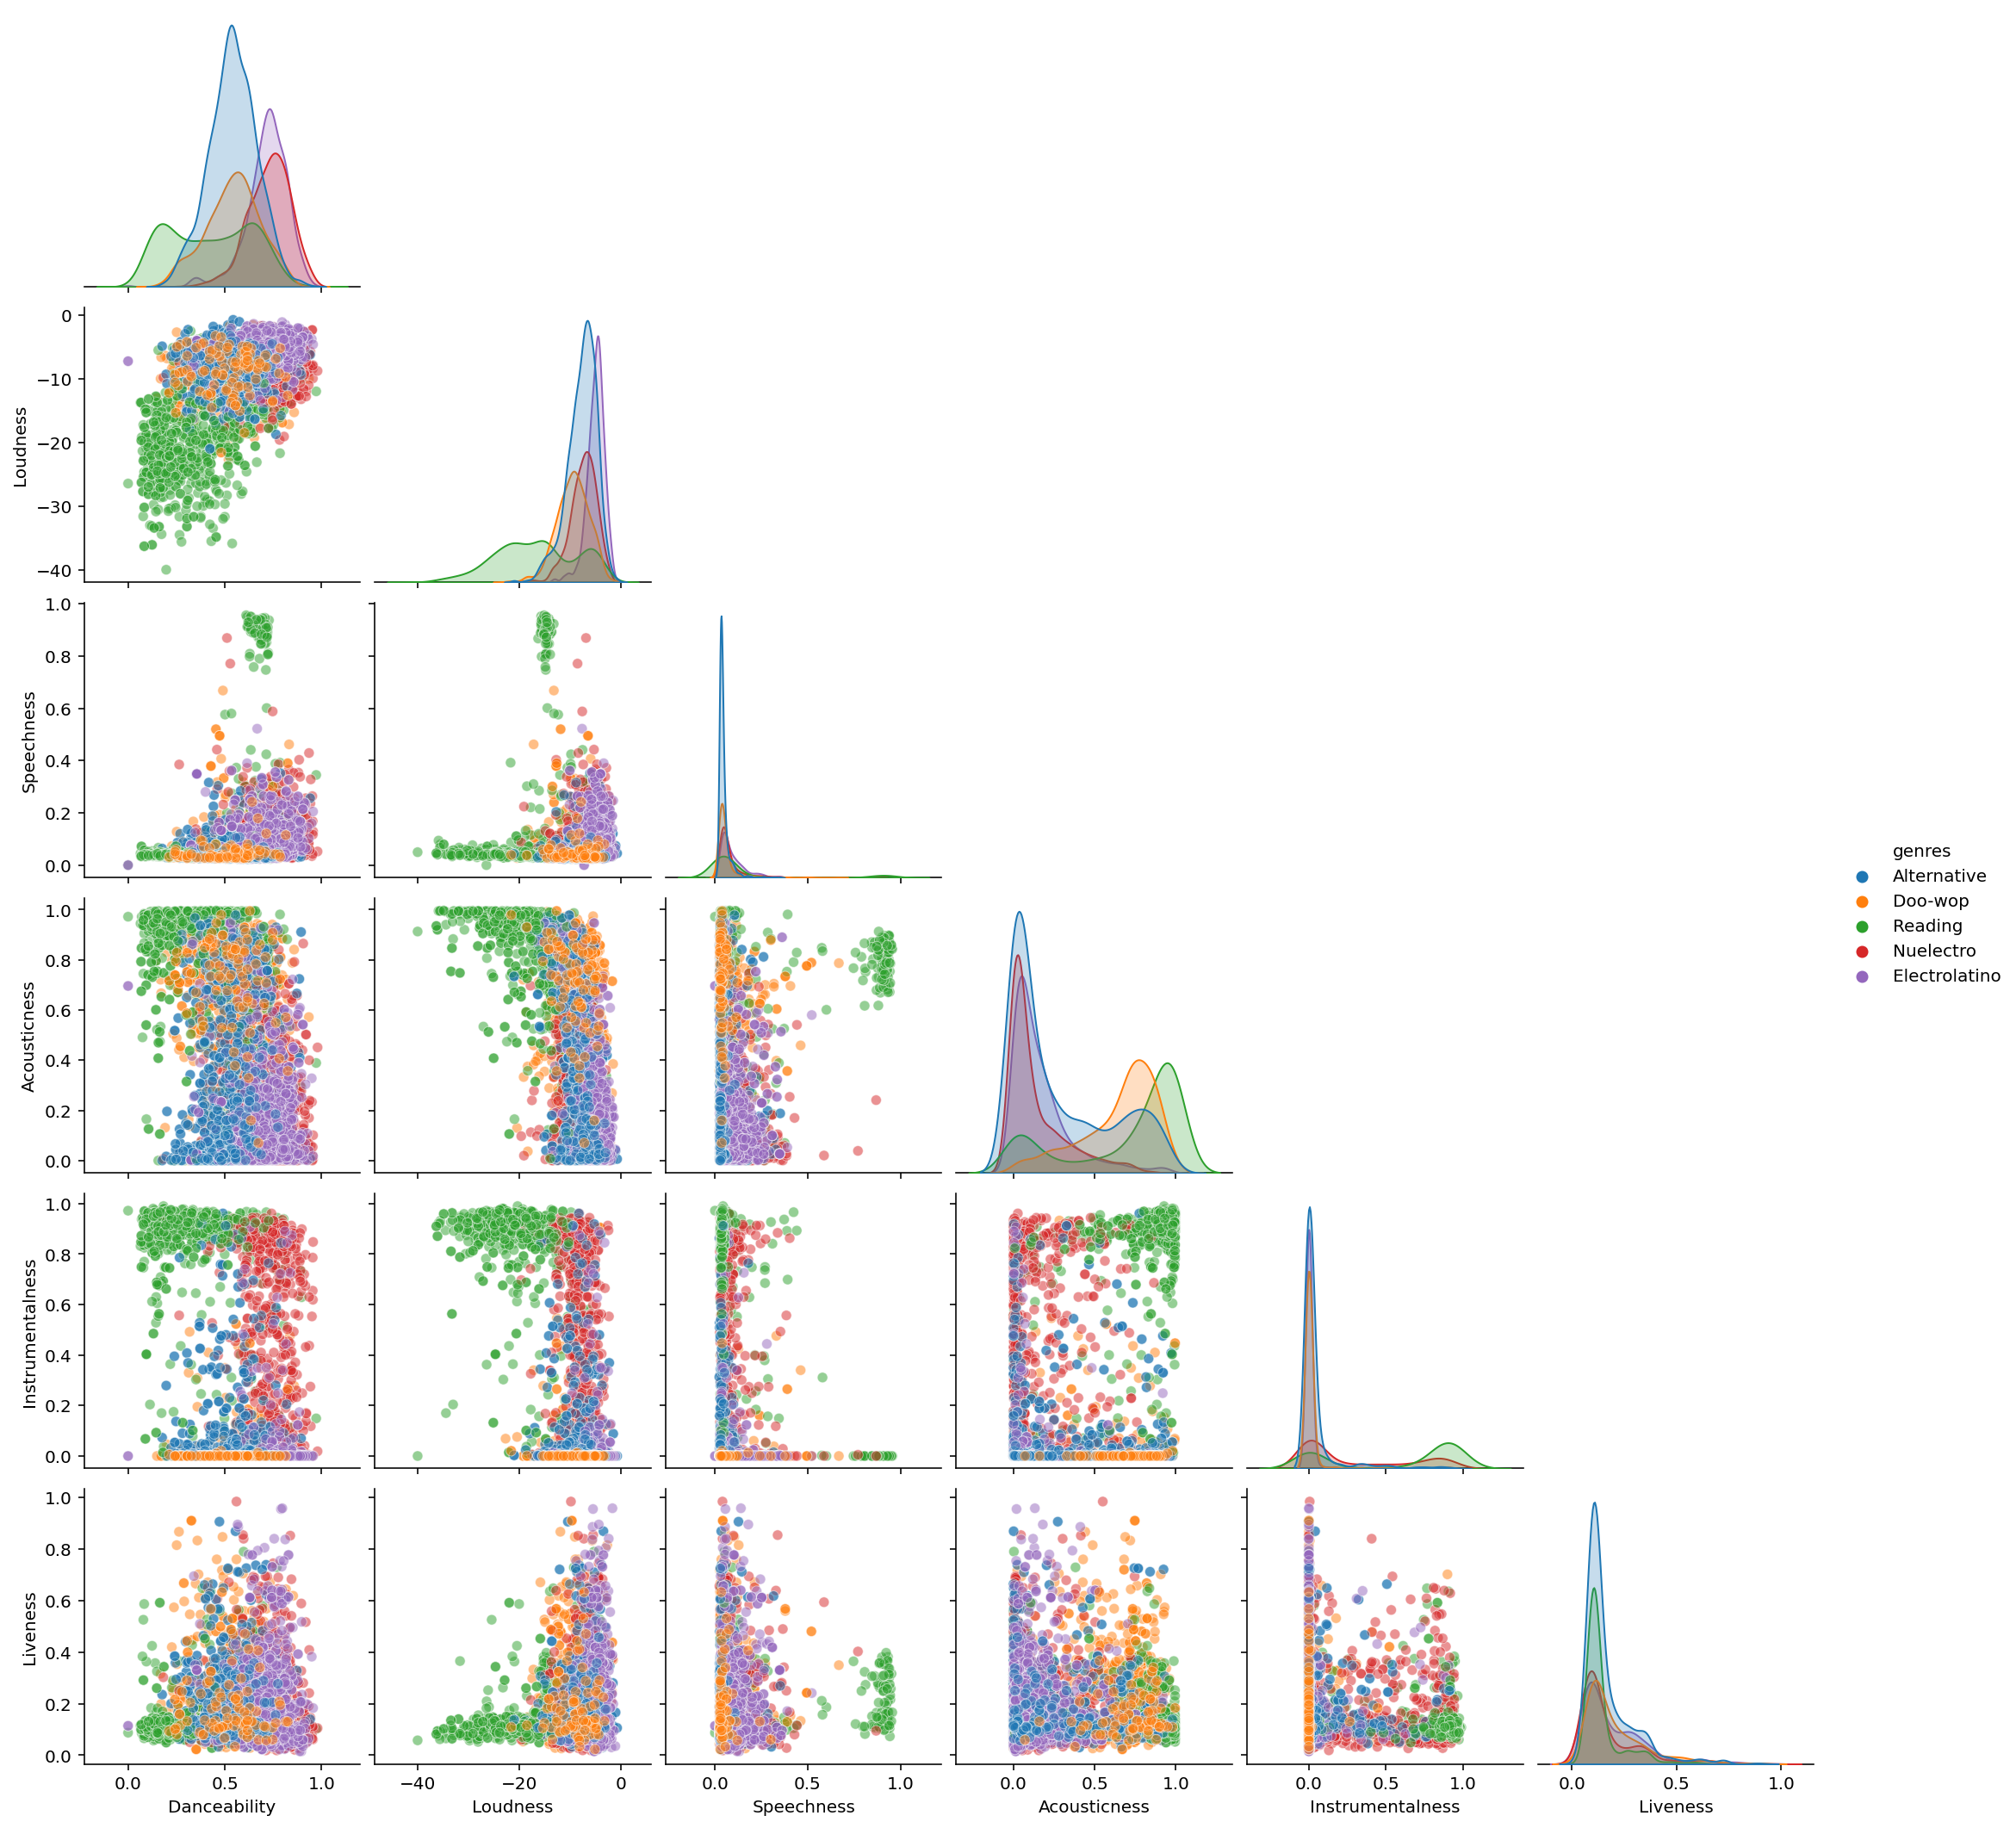

CPU times: user 7.98 s, sys: 554 ms, total: 8.54 s
Wall time: 7.97 s


In [29]:
%%time
sns.pairplot(df[feature_cols + [target_col]], hue = 'genres', corner = True, plot_kws={'alpha':0.5})
plt.show()

### Feature selection
Accuracy was low in the 30% range using the original 13 features that came with the dataset. We looked at the distribution of the features to try and see if we could reduce the number of features. 
This was done because we suspected a subset of the 13 features would have more influence on song classification accuracy.

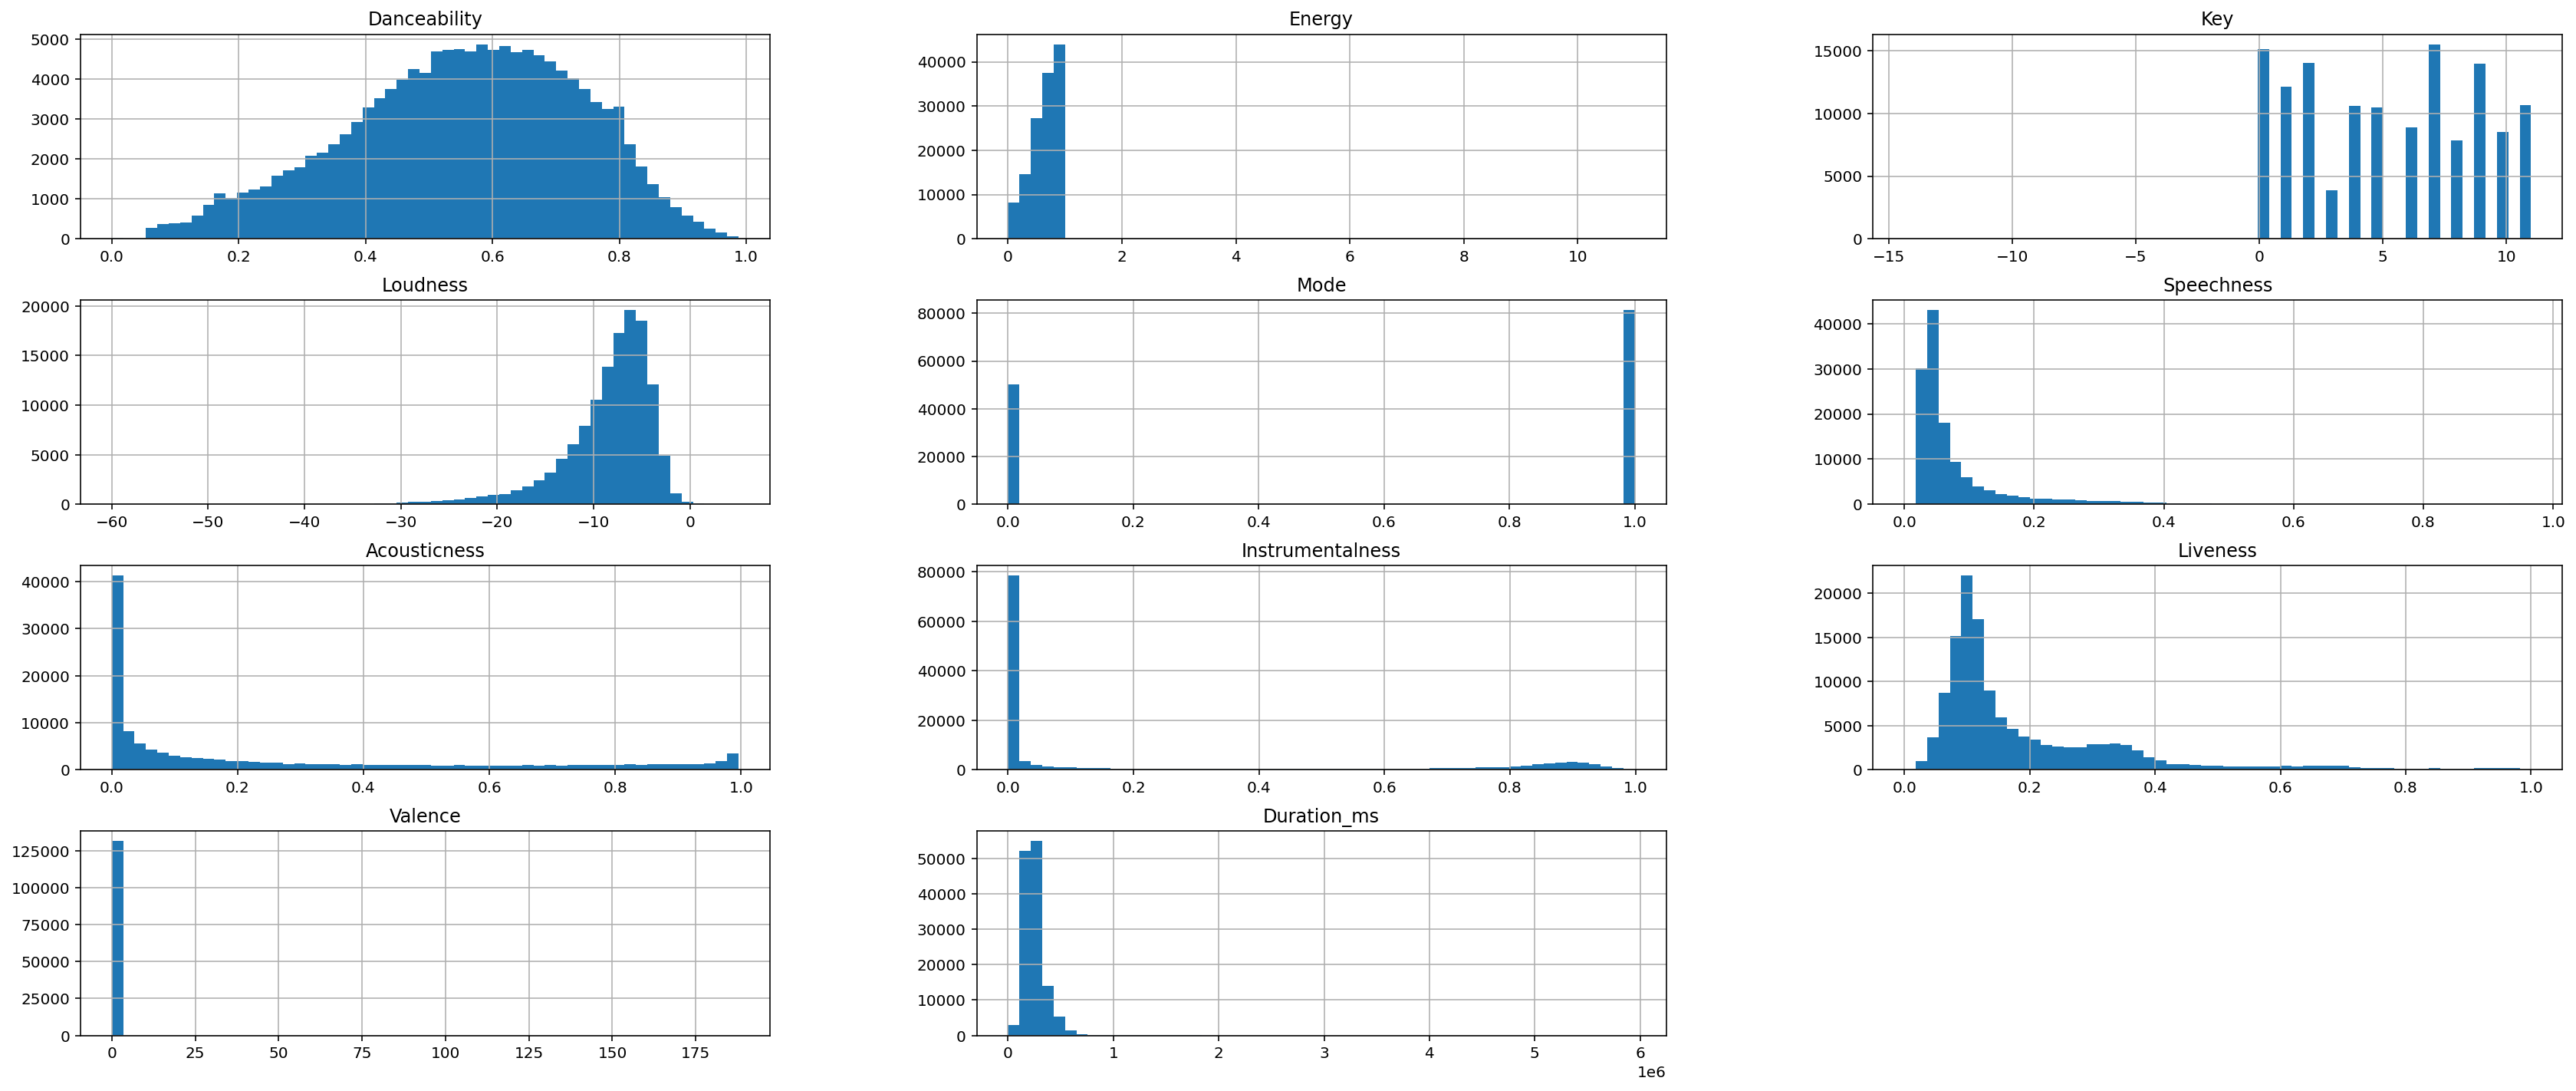

In [6]:
# Initial EDA 
# shows various distributions of features
plt.rcParams['figure.figsize'] = (29, 12) # increase size 
hist = music.hist(bins=55)

From the graph above we can see that 'Danceability', 'Loudness', 'Speechness', 'Acousticness', 'Instrumentalness', and 'Liveness' all follow a Gaussian distribution of some kind. The other features either had no visible distribution or lowered accuracy.
Thus below we reduce the features from 13 to 6.

In [7]:
# reduce features 
feature_cols = ['Danceability', 'Loudness',
                'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness'
                ]

Now we are ready to make our Train Test split

In [8]:
# take a subset of the data 10% OR any other subset

full_data = df[feature_cols + [target_col]]
df_small = full_data.groupby('genres').apply(lambda x: x.sample(frac = 0.99, random_state = 0)).reset_index(
    drop = True)


# This is a small set for testing 
X_small = df_small[feature_cols]
y_small = df_small[target_col]

# Create train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, stratify=y_small, test_size=0.2, random_state=42)

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (4553, 6)
Testing shape: (1139, 6)


### kNN (baseline)

In [21]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

# Label encoder for target (fitting it now to avoid unknown classes or different labels in testing)
le = LabelEncoder().fit(df[target_col].unique())

# KNN transformer and classifier
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=20, n_jobs = -1)  # default nn=20, testsize=0.1, frac=0.5, cut features set

# Pipelining
nca_pipe = Pipeline([
    ('nca', nca), 
    ('knn', knn)
])

# Fit
nca_pipe.fit(X_train, le.transform(y_train))

# Preliminary score
print(nca_pipe.score(X_test, le.transform(y_test)))

0.6435469710272168
CPU times: total: 2min 2s
Wall time: 1min 37s


## Model Selection: SVM, Logit, MLP, and PCA kNN 

### SVM 

In [17]:
from sklearn.metrics import classification_report
def plot_results(gridsearchcv):
    params = gridsearchcv.cv_results_["params"]
    ys = gridsearchcv.cv_results_["mean_test_score"]
    xs = ['|'.join(str(v) for v in param.values()) for param in params]
    yerr = gridsearchcv.cv_results_["std_test_score"]
    plt.errorbar(xs, ys, yerr / np.sqrt(gridsearchcv.cv), fmt='.k')
    plt.ylabel("f1")
    plt.xlabel("params")

In [14]:
np.random.seed(31415)

param_grid = {
    'kernel' : ['linear', 'rbf'],
    'C' : [1, 18, 50]
}

svm = SVC()

gscv = GridSearchCV(svm, param_grid, scoring = 'f1_micro', cv=5)

gscv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 18, 50], 'kernel': ['linear', 'rbf']},
             scoring='f1_micro')

               precision    recall  f1-score   support

  Alternative       0.65      0.69      0.67       375
      Doo-wop       0.61      0.76      0.68       192
Electrolatino       0.60      0.74      0.66       200
    Nuelectro       0.72      0.46      0.56       180
      Reading       0.98      0.69      0.81       192

     accuracy                           0.68      1139
    macro avg       0.71      0.67      0.68      1139
 weighted avg       0.70      0.68      0.68      1139



<AxesSubplot:>

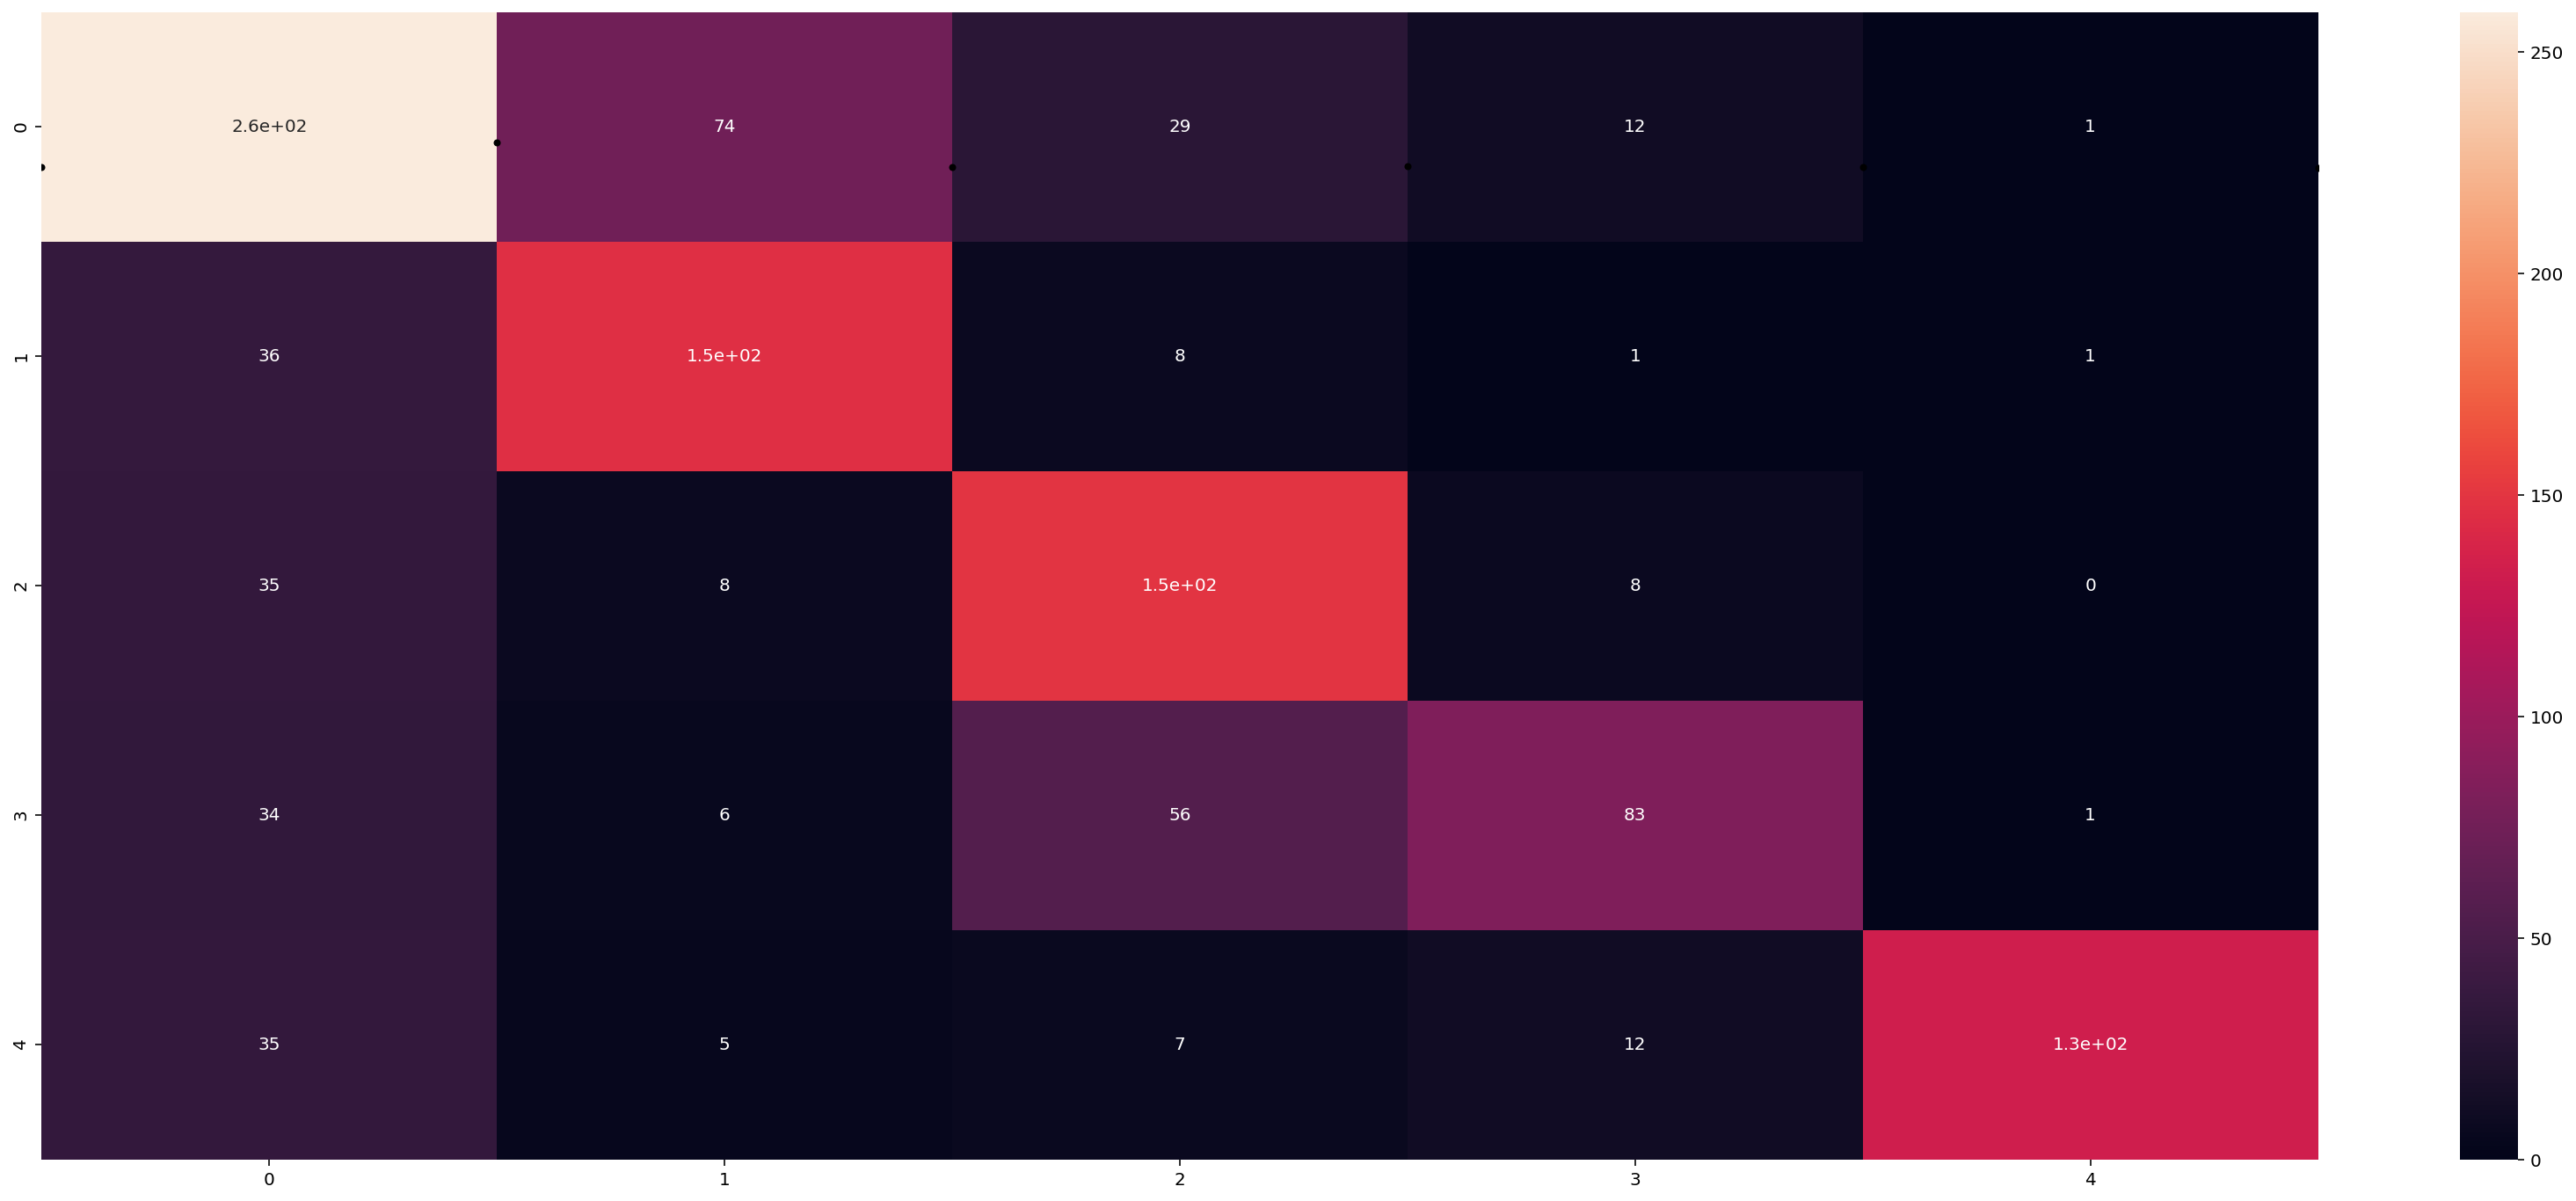

In [18]:
#Plotting gridsearch results and confusion matrix
y_pred = gscv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred))

sns.heatmap(confusion_matrix_df, annot=True)

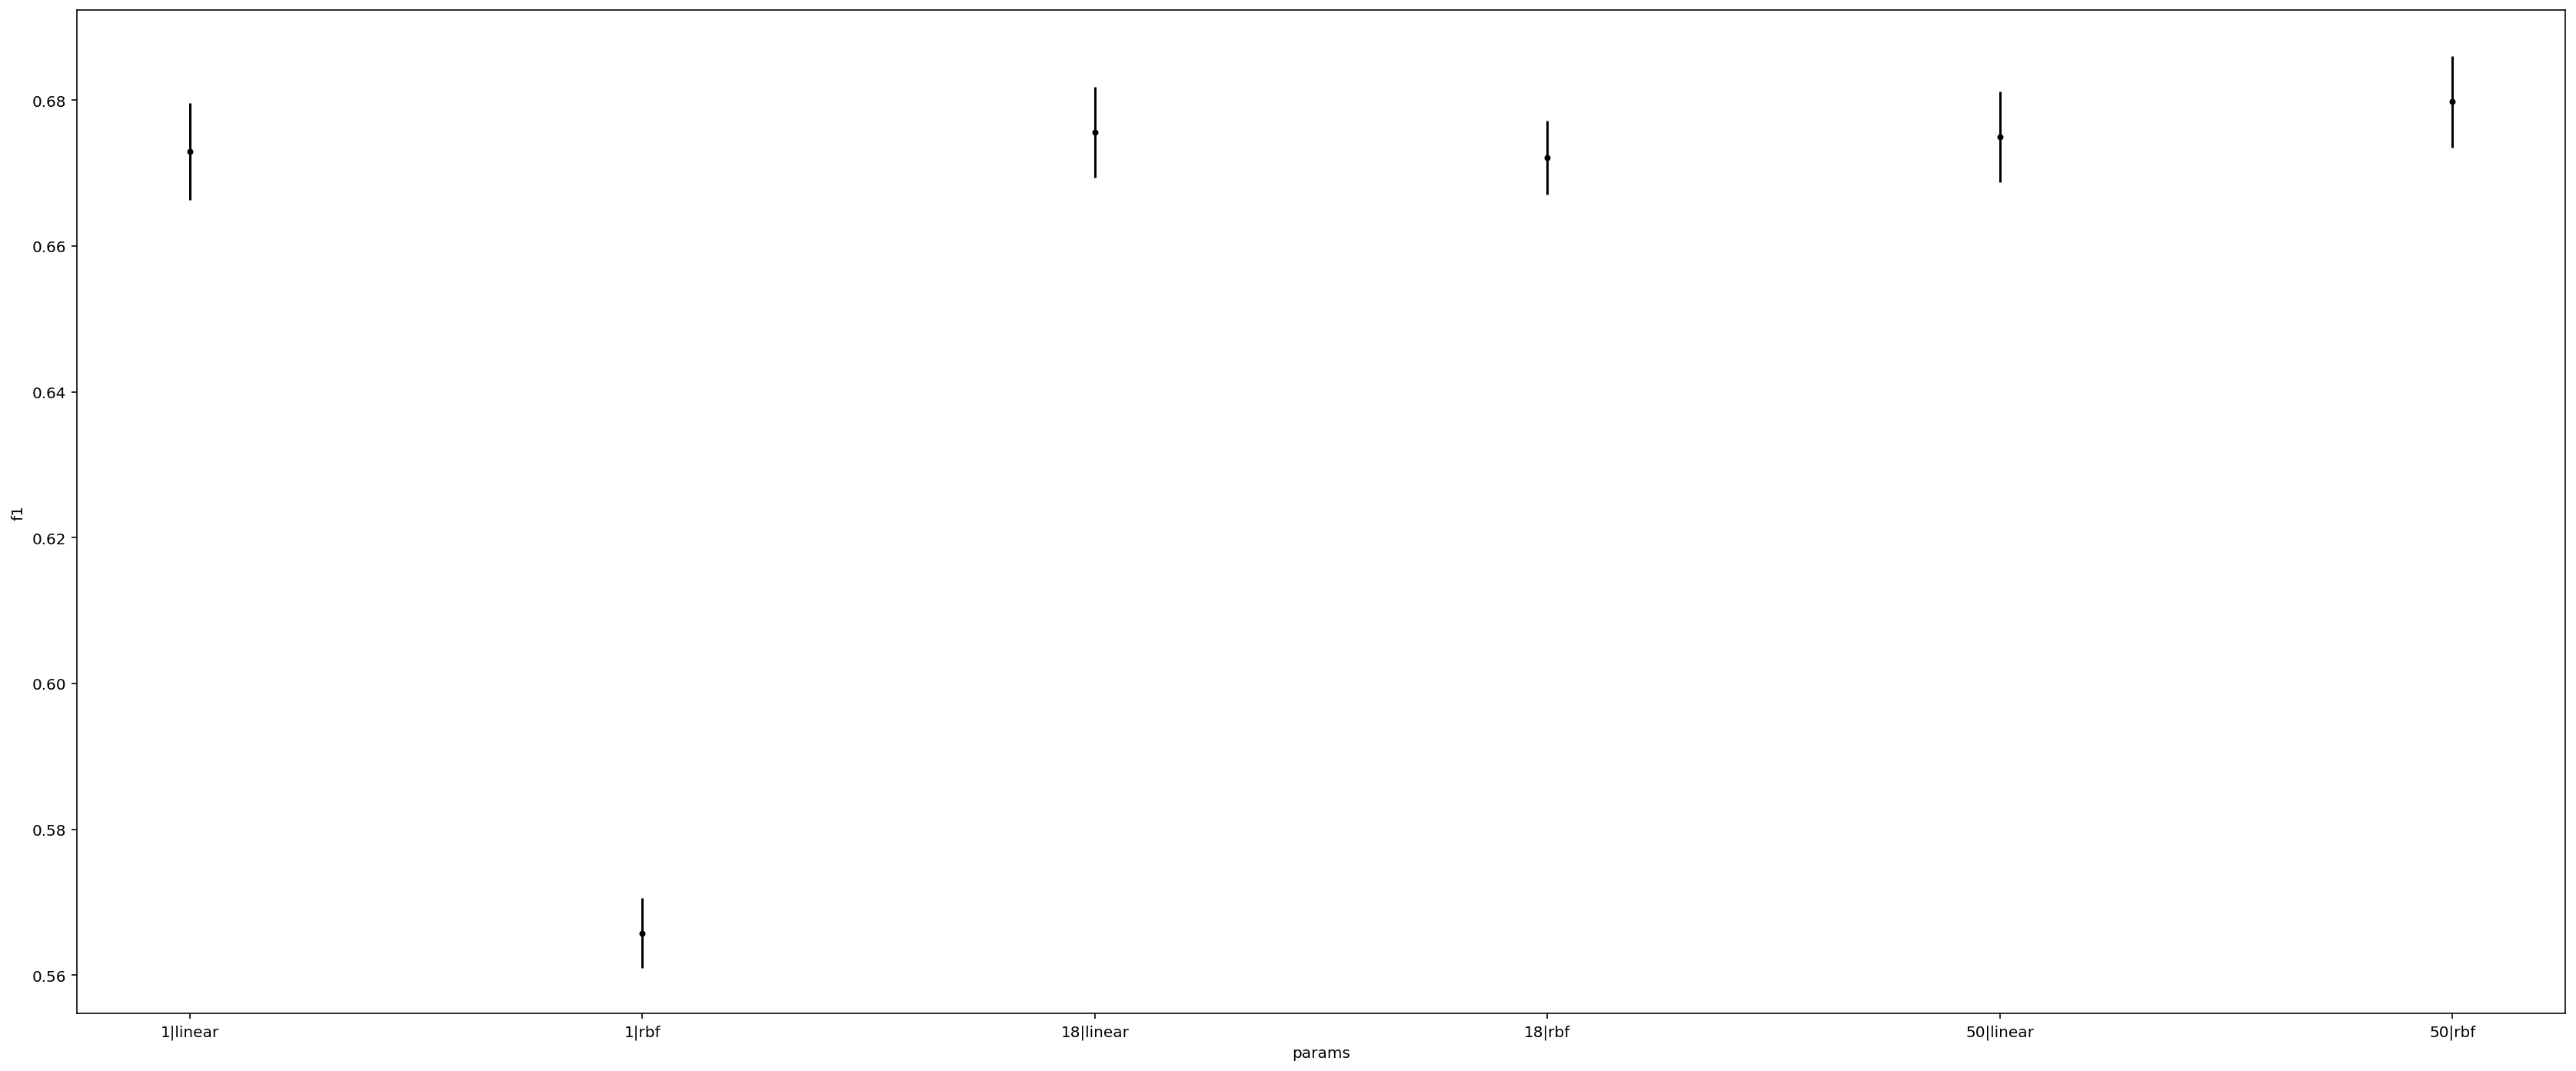

In [28]:
plot_results(gscv)

### Logistic Regression

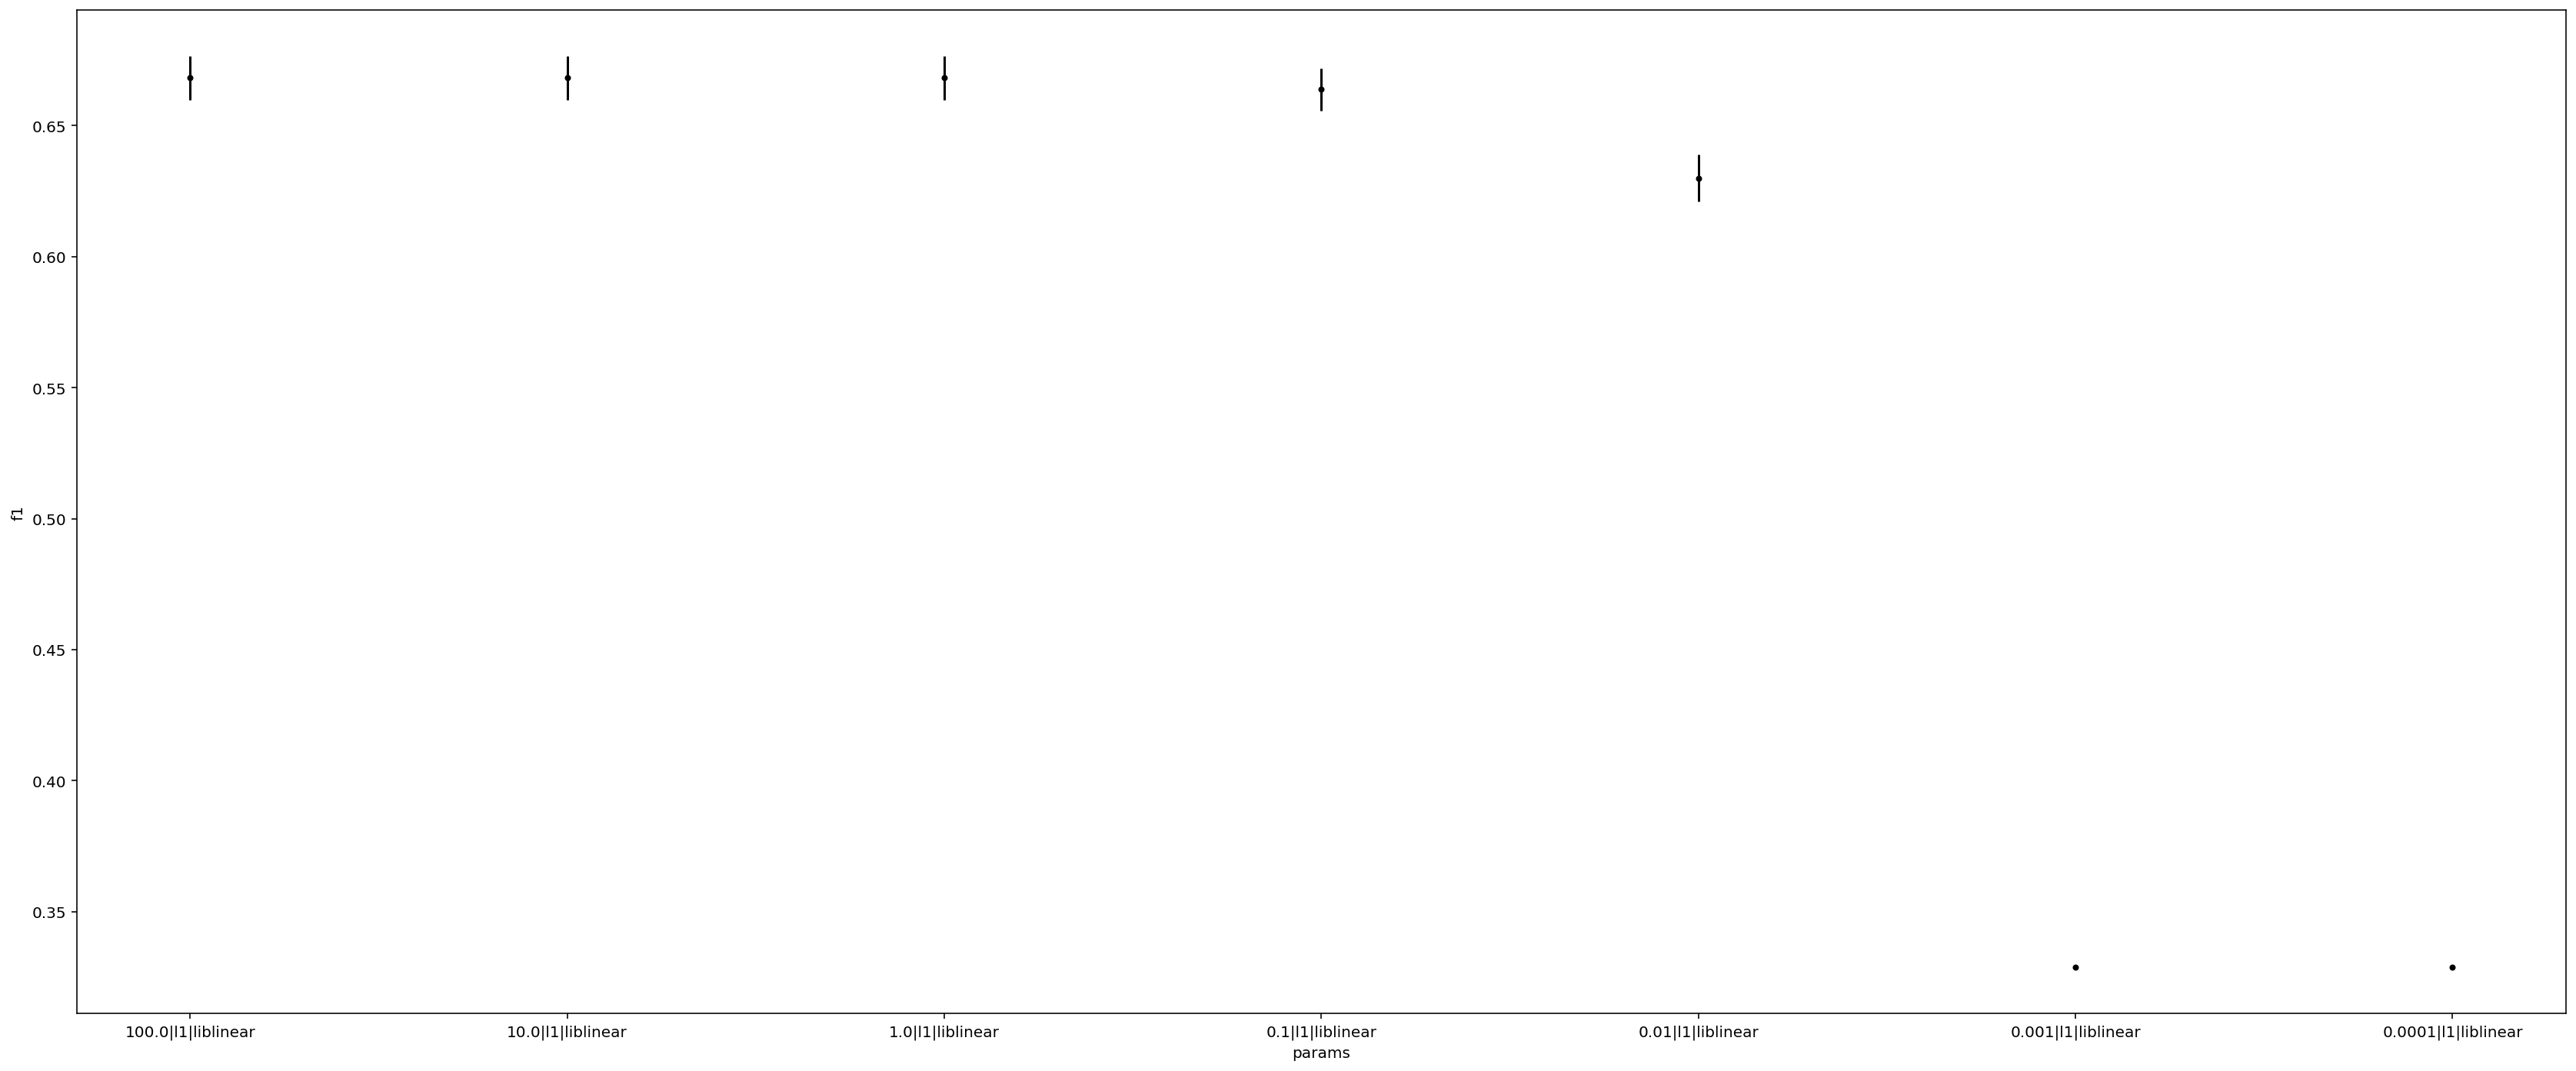

In [26]:
def plot_results(gridsearchcv):
    params = gridsearchcv.cv_results_["params"]
    ys = gridsearchcv.cv_results_["mean_test_score"]
    xs = ['|'.join(str(v) for v in param.values()) for param in params]
    yerr = gridsearchcv.cv_results_["std_test_score"]
    plt.errorbar(xs, ys, yerr / np.sqrt(gridsearchcv.cv), fmt='.k')
    plt.ylabel("f1")
    plt.xlabel("params")
    
def check_for_convergence(gridsearchcv):
    return gridsearchcv.best_estimator_.steps[-1][1].n_iter_ < gridsearchcv.best_estimator_.steps[-1][1].max_iter


np.random.seed(31415) 

scaler = StandardScaler()
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
logistic = LogisticRegression() # first step

# YOUR CODE HERE

pipe = Pipeline(steps=[("scaler", scaler), ("imputer", imp), ("logistic", logistic)])

# you don't need to modify the max_iter param. If you do, keep it under 1000
# hint, prefix your param names with logistic__ to pass it to the logistic step

# this grid when passed to the gridsearch will make a logistic regression 
# if you add more to the param_grid you can compare differnt models and see their IQR
param_grid = { 
    "logistic__C" : 10.0 ** -np.arange(-2, 5),
    "logistic__solver" : ['liblinear'], # use one algo from here it needs to be l1 https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
    "logistic__penalty" : ['l1'] # TA recommends using the l1 penalty 
}

# use f1_micro for scoring
# use 7 folds
gscv = GridSearchCV(pipe, param_grid, scoring = 'f1_micro', cv=7)

# gscv.fit(X_train, y_train)
gscv.fit(X_train, y_train)

plot_results(gscv)

### MLP

We shall construct a simple 3 layered perceptron with batch normalization and dropout for regularization.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(df[target_col].unique())

#Scale and convert data to np array
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(le.transform(y_train))
X_test, y_test = np.array(X_test), np.array(le.transform(y_test))

In [7]:
label_dict = {i:le.inverse_transform([i])[0] for i in range(5)}
#Label dictionary for confusion matrix
label_dict

{0: 'Alternative',
 1: 'Doo-wop',
 2: 'Electrolatino',
 3: 'Nuelectro',
 4: 'Reading'}

In [8]:
# Dataset class to load in data into network
class GenreDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [9]:
# Create Validation test to chec for overfitting
X_train_s, X_val, y_train_s, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=21)

In [10]:
train_dataset = GenreDataset(torch.from_numpy(X_train_s).float(), torch.from_numpy(y_train_s).long())
val_dataset = GenreDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = GenreDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [23]:
# Initalize training parameters
EPOCHS = 15
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 5

In [24]:
# Initalize data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [25]:
# MLP Network

class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512) 
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x) # 1st Layer 
        x = self.batchnorm1(x) # Batch normalization
        x = self.relu(x) # ReLU Non Linearization
        
        x = self.layer_2(x) # 2nd Layer 
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x) # Dropout layer, randomly drops values to prevent overfitting
        
        x = self.layer_3(x) # 3rd layer
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x) # Output layer, will need to softmax while testing

        
        return x

In [26]:
# Check and activate gpu

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [27]:
# Initalize Model and set optimizer and metric

model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=13, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [28]:
# Accuracy Metric

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [29]:
# Dictionaries for plotting training curve

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [30]:
# Start Training

from tqdm import tqdm

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    print("Training...")

    # Set model to train mode
    model.train()

    # Feed model in batches
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        

    print("Validating")    
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        #Stop training model and begin evaluation on validation set
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                                
        
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


  0%|          | 0/15 [00:00<?, ?it/s]

Training...
Validating


  7%|▋         | 1/15 [00:02<00:34,  2.45s/it]

Epoch 001: | Train Loss: 0.95846 | Val Loss: 0.72263 | Train Acc: 65.348| Val Acc: 76.096
Training...
Validating


 13%|█▎        | 2/15 [00:04<00:28,  2.18s/it]

Epoch 002: | Train Loss: 0.79594 | Val Loss: 0.67194 | Train Acc: 70.887| Val Acc: 76.754
Training...
Validating


 20%|██        | 3/15 [00:06<00:25,  2.09s/it]

Epoch 003: | Train Loss: 0.75127 | Val Loss: 0.64809 | Train Acc: 72.871| Val Acc: 78.070
Training...
Validating


 27%|██▋       | 4/15 [00:08<00:22,  2.07s/it]

Epoch 004: | Train Loss: 0.71493 | Val Loss: 0.63581 | Train Acc: 74.160| Val Acc: 78.070
Training...
Validating


 33%|███▎      | 5/15 [00:10<00:20,  2.03s/it]

Epoch 005: | Train Loss: 0.68910 | Val Loss: 0.62981 | Train Acc: 75.098| Val Acc: 78.289
Training...
Validating


 40%|████      | 6/15 [00:12<00:18,  2.01s/it]

Epoch 006: | Train Loss: 0.66830 | Val Loss: 0.62600 | Train Acc: 76.168| Val Acc: 78.509
Training...
Validating


 47%|████▋     | 7/15 [00:14<00:15,  2.00s/it]

Epoch 007: | Train Loss: 0.64151 | Val Loss: 0.62077 | Train Acc: 76.223| Val Acc: 78.728
Training...
Validating


 53%|█████▎    | 8/15 [00:16<00:14,  2.02s/it]

Epoch 008: | Train Loss: 0.62052 | Val Loss: 0.62139 | Train Acc: 76.816| Val Acc: 78.509
Training...
Validating


 60%|██████    | 9/15 [00:18<00:12,  2.04s/it]

Epoch 009: | Train Loss: 0.60735 | Val Loss: 0.62526 | Train Acc: 77.754| Val Acc: 78.509
Training...
Validating


 67%|██████▋   | 10/15 [00:20<00:10,  2.11s/it]

Epoch 010: | Train Loss: 0.57964 | Val Loss: 0.61290 | Train Acc: 79.031| Val Acc: 77.412
Training...
Validating


 73%|███████▎  | 11/15 [00:22<00:08,  2.07s/it]

Epoch 011: | Train Loss: 0.56373 | Val Loss: 0.61677 | Train Acc: 79.285| Val Acc: 76.974
Training...
Validating


 80%|████████  | 12/15 [00:24<00:06,  2.03s/it]

Epoch 012: | Train Loss: 0.54587 | Val Loss: 0.63589 | Train Acc: 80.039| Val Acc: 77.412
Training...
Validating


 87%|████████▋ | 13/15 [00:26<00:04,  2.01s/it]

Epoch 013: | Train Loss: 0.53487 | Val Loss: 0.65108 | Train Acc: 80.527| Val Acc: 76.535
Training...
Validating


 93%|█████████▎| 14/15 [00:28<00:02,  2.04s/it]

Epoch 014: | Train Loss: 0.50313 | Val Loss: 0.65470 | Train Acc: 81.434| Val Acc: 77.632
Training...
Validating


100%|██████████| 15/15 [00:30<00:00,  2.05s/it]

Epoch 015: | Train Loss: 0.48816 | Val Loss: 0.63326 | Train Acc: 82.684| Val Acc: 78.509


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

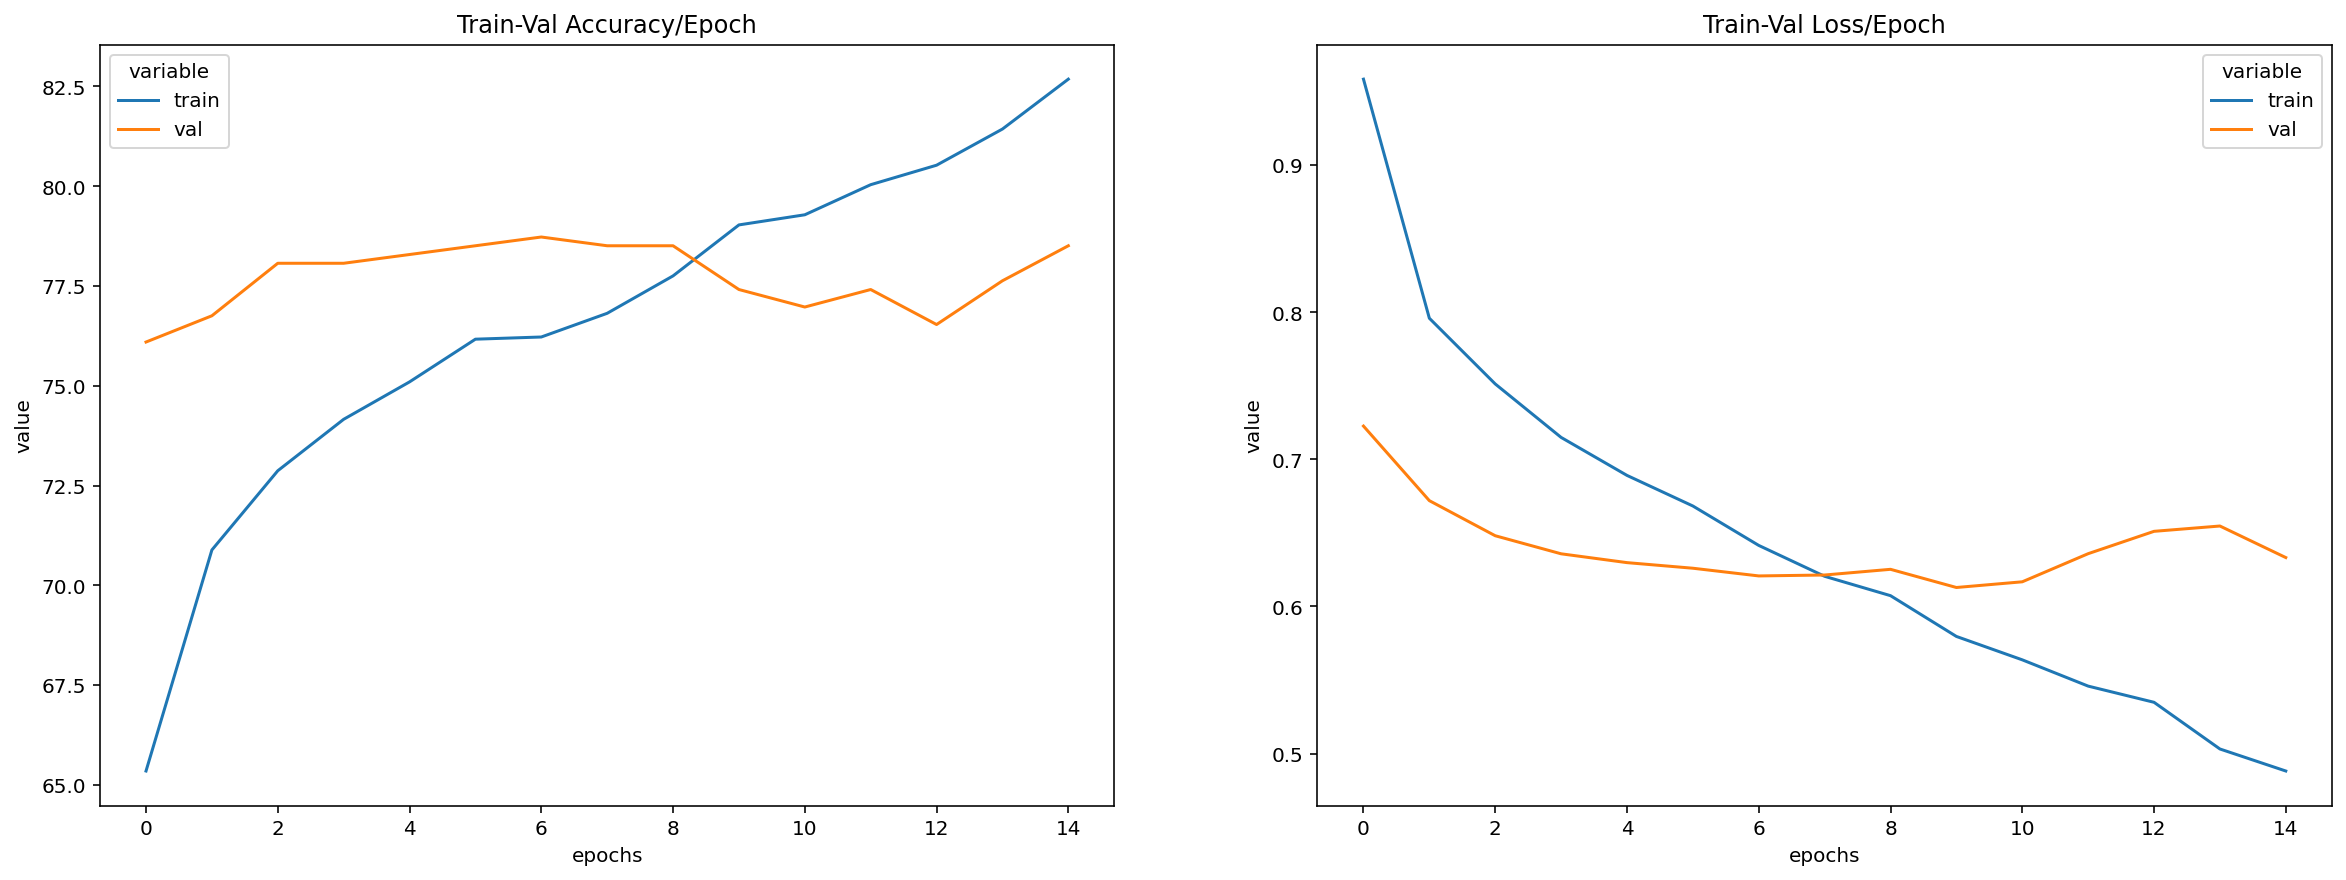

In [31]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

We determined that the model starts heavily overfitting at around 20 epochs and thus limited training to 15 epochs. The training and validation curves above suggest low overfitting as training and validation accuracy is similar.

In [32]:
# Test on test set

y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot:>

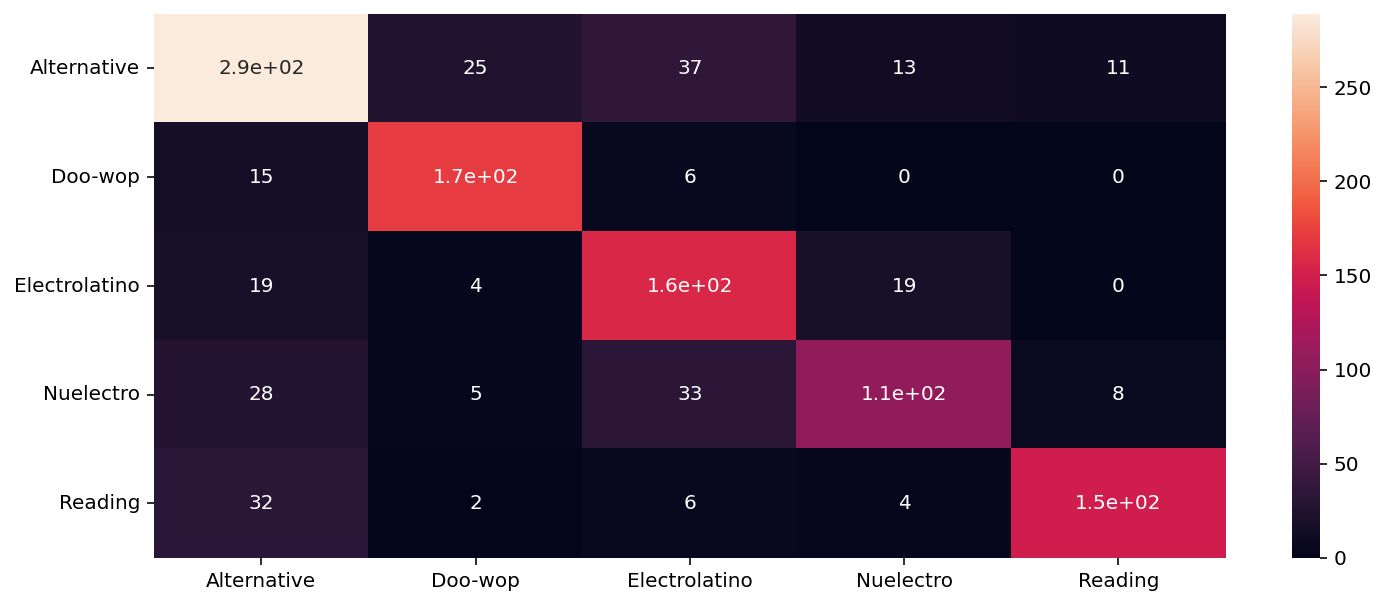

In [33]:
# Confusion matrix of test set

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=label_dict, index=label_dict)

sns.heatmap(confusion_matrix_df, annot=True)

In [34]:
# Metrics od model performance of each class 

print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       375
           1       0.83      0.89      0.86       192
           2       0.66      0.79      0.72       200
           3       0.75      0.59      0.66       180
           4       0.89      0.77      0.82       192

    accuracy                           0.77      1139
   macro avg       0.77      0.76      0.76      1139
weighted avg       0.77      0.77      0.76      1139



Our MLP acheived an accuracy of 77% on the test set. 

### KNN with PCA + GridsearchCV
Since KNN suffers from high dimensionality, we attempted to reduce dimensions using PCA, a preprocessing technique used to reduce dimensionality. The technique increases interpretability but also minimizes information loss. We applied this to the KNN pipeline hoping to improve the performance. 



In [23]:
%%time
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVC
pca = PCA(n_components = 0.95)
scaler = StandardScaler()

# KNN transformer and classifier
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_jobs = -1) 

# Pipelining
pipe = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('nca', nca), 
    ('knn', knn)
])

param_grid = {
    "pca__n_components" : [0.9, 0.95],
    "knn__n_neighbors" : [5, 10, 20, 25]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring = 'f1_micro', verbose = 10, cv = 5)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameter (CV score=0.684):
{'knn__n_neighbors': 20, 'pca__n_components': 0.9}
CPU times: user 3min 10s, sys: 11min 57s, total: 15min 8s
Wall time: 9min 14s


As you can see, the performance of KNN has improved from 0.64 to ~0.7 by using PCA to reduce dimensionality.

We also used GridsearchCV to choose our hyperparameters for the n_neighbors in KNN and n_components in PCA. The hyperparamaters we ended up using are n_neighbors = 20 and n_components = 0.9.

---
GridsearchCV results for KNN:

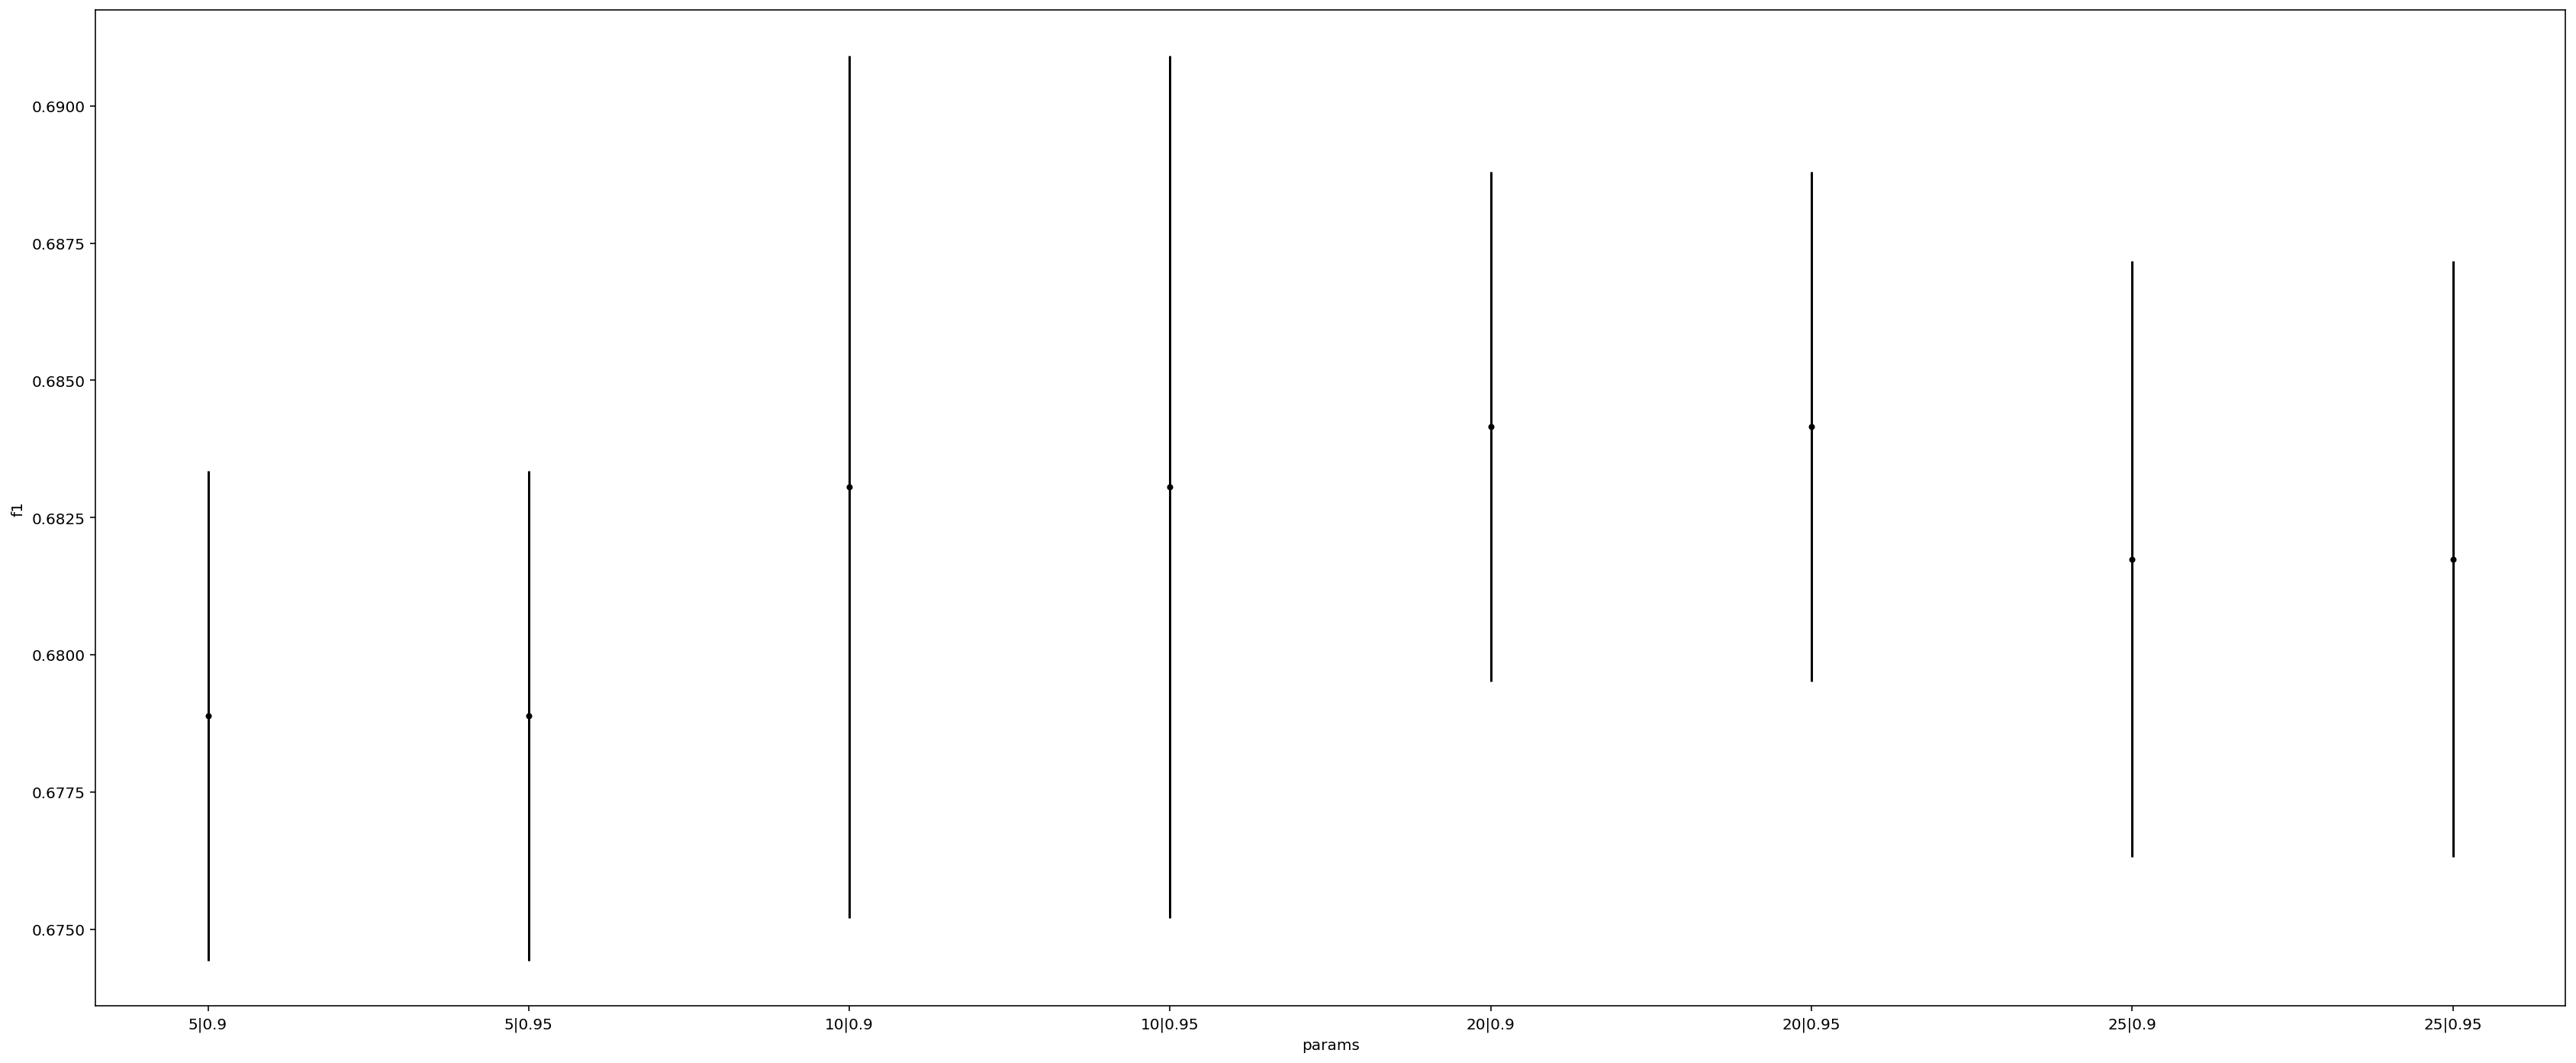

In [27]:
plot_results(search)

               precision    recall  f1-score   support

  Alternative       0.64      0.79      0.71       375
      Doo-wop       0.65      0.59      0.62       192
Electrolatino       0.61      0.75      0.68       200
    Nuelectro       0.69      0.43      0.53       180
      Reading       0.96      0.72      0.82       192

     accuracy                           0.68      1139
    macro avg       0.71      0.66      0.67      1139
 weighted avg       0.70      0.68      0.68      1139



<AxesSubplot:>

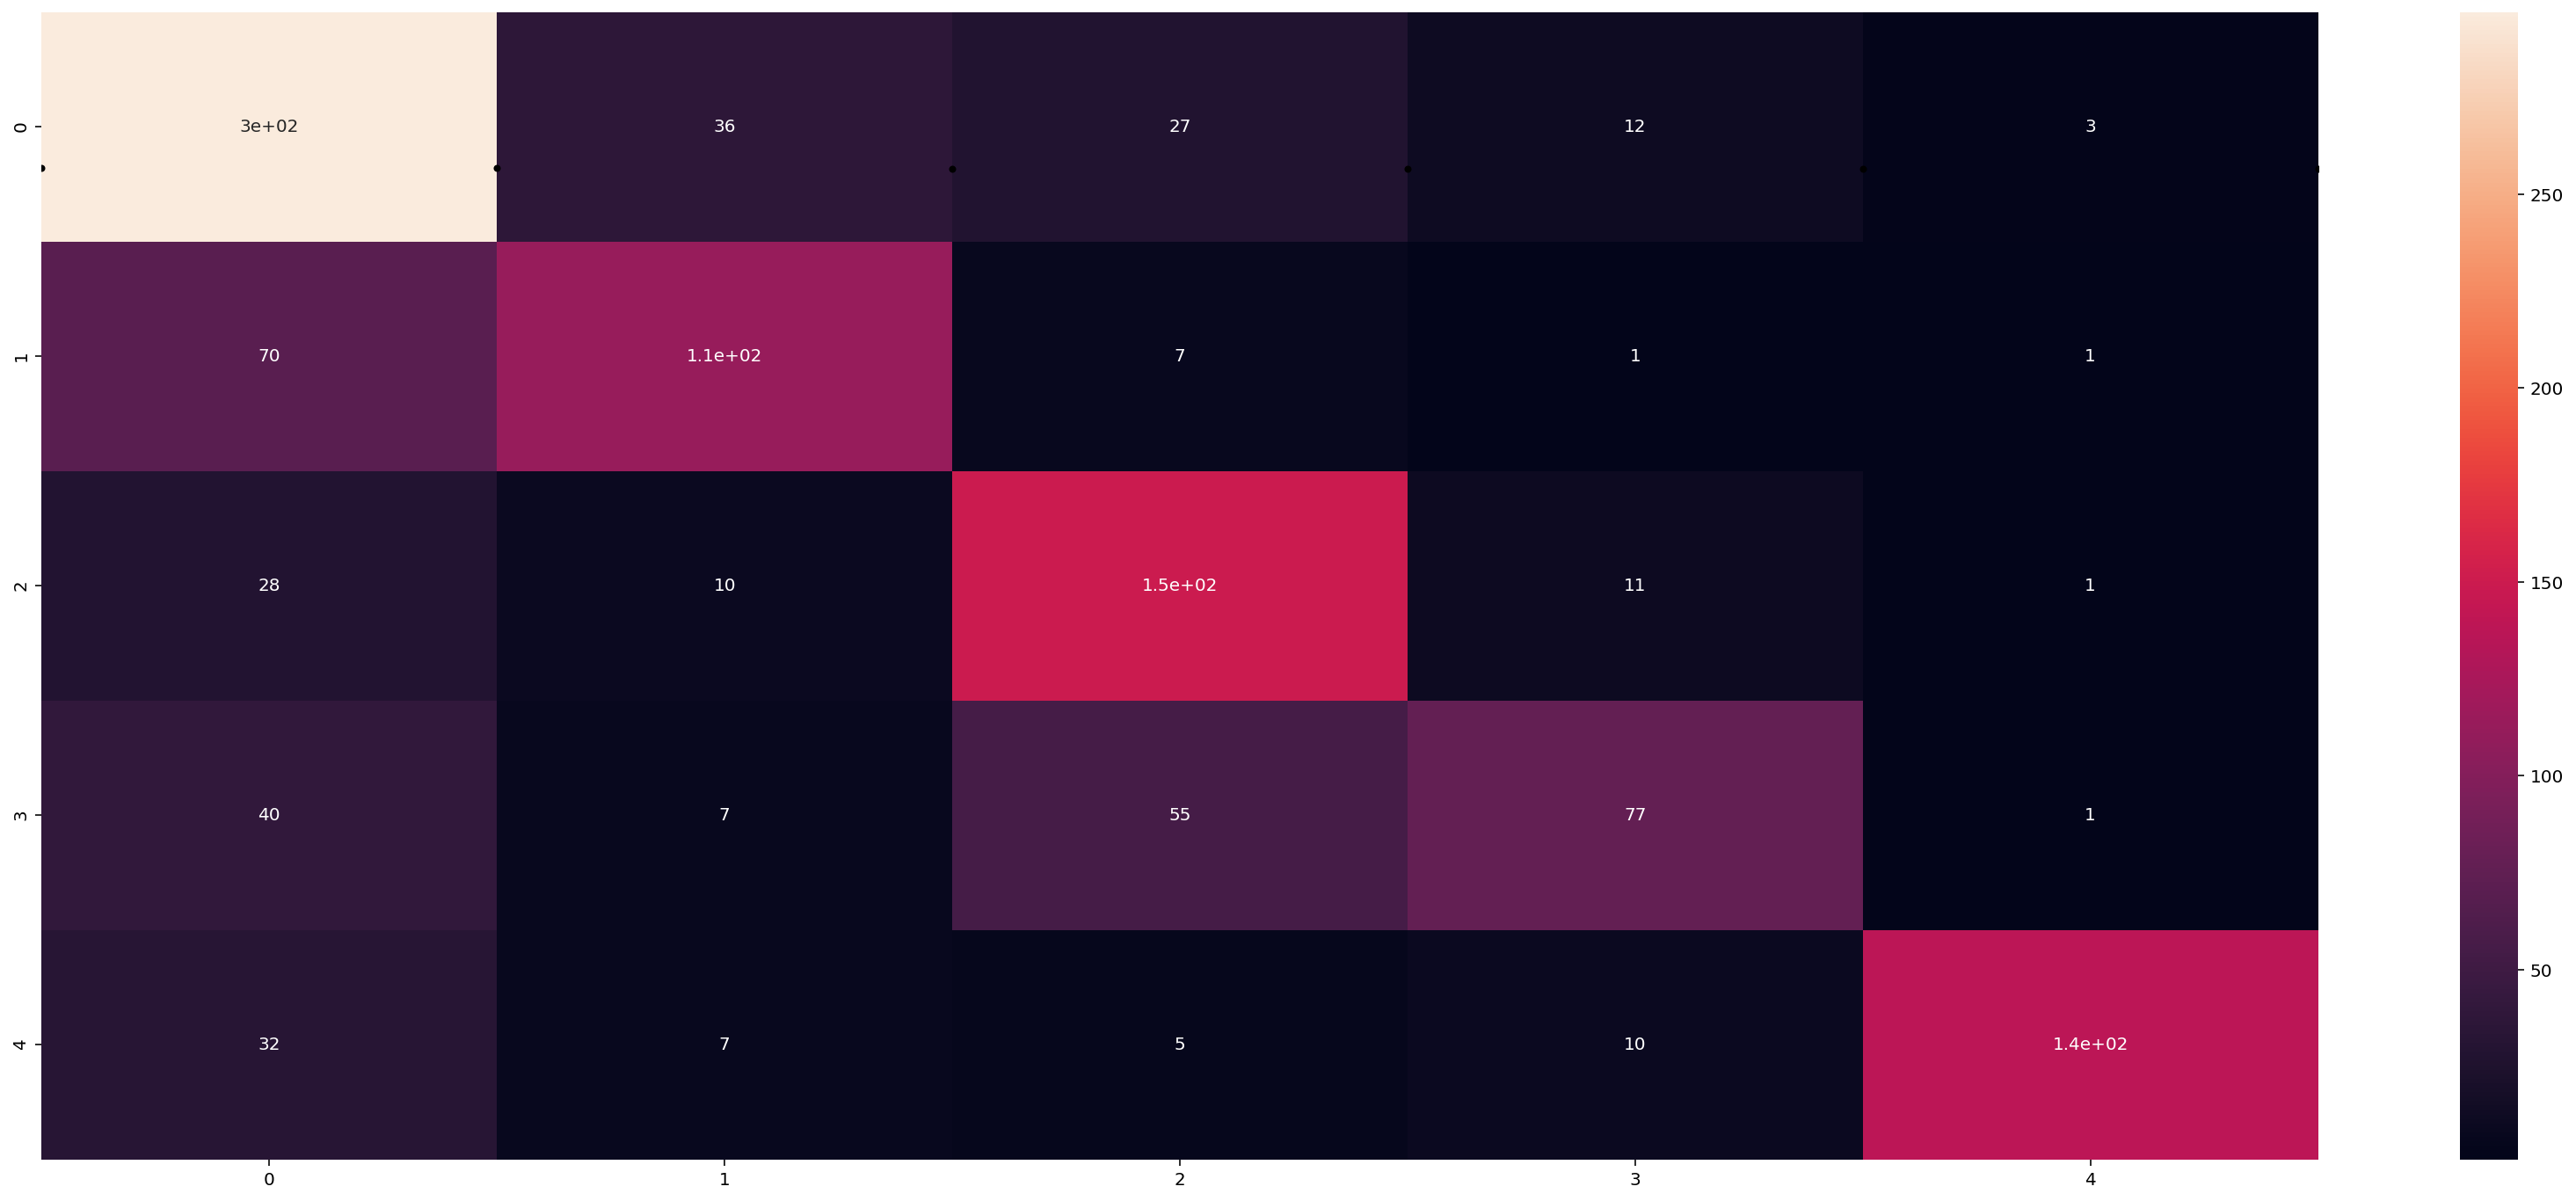

[CV 5/5; 1/8] START knn__n_neighbors=5, pca__n_components=0.9...................
[CV 5/5; 1/8] END knn__n_neighbors=5, pca__n_components=0.9;, score=0.665 total time=  45.4s
[CV 4/5; 2/8] START knn__n_neighbors=5, pca__n_components=0.95..................
[CV 4/5; 2/8] END knn__n_neighbors=5, pca__n_components=0.95;, score=0.682 total time= 1.2min
[CV 4/5; 4/8] START knn__n_neighbors=10, pca__n_components=0.95.................
[CV 4/5; 4/8] END knn__n_neighbors=10, pca__n_components=0.95;, score=0.669 total time= 1.2min
[CV 3/5; 6/8] START knn__n_neighbors=20, pca__n_components=0.95.................
[CV 3/5; 6/8] END knn__n_neighbors=20, pca__n_components=0.95;, score=0.696 total time=  52.4s
[CV 5/5; 7/8] START knn__n_neighbors=25, pca__n_components=0.9..................
[CV 5/5; 7/8] END knn__n_neighbors=25, pca__n_components=0.9;, score=0.666 total time=  46.3s
[CV 1/5; 1/8] START knn__n_neighbors=5, pca__n_components=0.9...................
[CV 1/5; 1/8] END knn__n_neighbors=5, pca__

In [26]:
y_pred = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred))

sns.heatmap(confusion_matrix_df, annot=True)

# Discussion

### Interpreting the result

Our MLP and KNN (with PCA) models performed the best across algorithms according to our metrics, which we believe is an indicator that our data is highly non-linear.

In addition to this, we found that the dataset was too expansive in genre definitions to accurately classify songs into them. By filtering our dataset and selecting only the genres that were well-represented, we were able to successfully use supervised ML techniques to classify a song's genre.

### Limitations

We discovered that the genre labels in our dataset were extremely specific and expansive. The dataset contained a total of 2800 unique genres.

We first tried to solve this problem by using the label names to generalize these categories but this yielded poor results as our generalizations were too broad.

We then settled on simply using the most 5 most common genres but this came with the drawback of cutting down our dataset significantly. We believe that a dataset that has broader but more meaningful labels will counteract these drawbacks.

We also realized that running our algorithms on a huge dataset took immense computational resources that we had limited access too. Thus the filtering of our dataset into the top 5 genres helped address this as well by shrinking our dataset. 

An additional limitation of this project is that our model is incapable of telling if a song does not fit into any of the top 5 genres, such as by classifying it into a sixth genre 'Other'. This is possible expansion on this project for the future, but would likely require a lot more data and therefore training times.

### Ethics & Privacy

In regards to data privacy, there is none to be concern about as the data we are going to use to train our models are simply song features, which are public information on Spotify provided by the Spotify API. Since these songs are available on Spotify, it means that the artists willingly published their songs to the public.

One ethical concern with the datasets we will use is the possible biases. Since we cannot sample randomly from the set of every song in existence on Spotify, we have to resort to using sample datasets with songs that are mostly well known and popular. This might introduce bias into our data as there is a possibility that popular or well known songs share similar audio features. Less popular song genres may be excluded from the model's training dataset, which could have vastly different audio features. Additionally, there are numerous songs in different languages and cultures that public datasets may not cover. Songs with different cultural backgrounds may have vastly different features, and just analyzing popular songs in America is not representative of all the songs in the world. 

As such, our machine learning model may have more difficulty in identifying the correct valence for less well-known songs. One possible solution to this issue is to use a more diverse set of songs as our dataset, but from a realistic perspective it is impossible to sample from every form of music in existence. As such, the only solution is to address that the model we create can only be applied to popular or well-known songs of today in particularly the US.

### Conclusion

This project seeked to explore if we can use supervised machine learning techniques to uncover if it is possible to predict genere labels for different kinds of music. We were sucessfully able to classify music into 5 distinct genres using their audio features as described by the Spotify API. We found the most success while using a Multi Layer Perceptron (f1: 0.76) and K-Nearest Neighbors (f1: 0.74) which suggests our data is non linear in nature. Our findings suggest that similar non linear techniques might be suitable for genre classification tasks. We recommend further exploration on datasets with more datapoints and better genre labels using the techniques discussed in this project.

# Footnotes
<a name="bissnote"></a>1.[^](#biss): Biss, Madars. (2021) Rhythm Tips for Identifying Music Genres by Ear. *Musical U*. https://www.musical-u.com/learn/rhythm-tips-for-identifying-music-genres-by-ear/<br> 
<a name="taggnote"></a>2.[^](#tagg): Fabbri, Franco. (1980) A Theory of Musical Genres:
Two Applications. *Popular Music Perspectives*. https://www.tagg.org/xpdfs/ffabbri81a.pdf<br> 
<a name="greenbergnote"></a>3.[^](#greenberg): Greenberg, David M. (6, August 2016) Musical genres are out of date – but this new system explains why you might like both jazz and hip hop. *EconoTimes*. http://www.econotimes.com/Musical-genres-are-out-of-date-%E2%80%93-but-this-new-system-explains-why-you-might-like-both-jazz-and-hip-hop-244941<br> 
<a name="venturottnote"></a>4.[^](#venturott): Venturott, Pedro H G. (31, January 2021) Predicting Music Genres Using Waveform Features. *Towards Data Science*. https://towardsdatascience.com/predicting-music-genres-using-waveform-features-5080e788eb64<br> 
<a name="elbirnote"></a>5.[^](#elbir): Elbir, Ahmet et. al. (2018) Music Genre Classification and Recommendation by Using Machine Learning Techniques. *IEEE*. https://ieeexplore.ieee.org/document/8554016<br> 